In [1]:
# Out of distribution -> Model is in production and tries to predict
# something it has never seen before

In [3]:
# Transfer knowledge through the embedding when we embed similar words and
# they end up in the roughly the same space

In [4]:
# Hyperparameter -> A configurable designed parameter chosen by the person
# who designs the neural network

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for (i, s) in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for (s, i) in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [156]:
# Build the dataset

# Context length: how many characters do we take to predict the next one?
block_size = 3
# Input & Output(labels) tensors initialized as empty
X, Y = [], []

for w in words:
    #print(w)
    # Start with a padded context, of zero context
    # Essentially starting with the empty context with the given block size
    context = [0] * block_size
    # Iterate through each character in the word with the '.' representing the ending token
    for ch in w + '.':
        # Take the index of the current character
        idx = stoi[ch]
        # We store the current running context
        X.append(context)
        # For this current context, we store the label, in other words,
        # The character that we want to predict as being next
        Y.append(idx)
        # Print everything
        #print(''.join(itos[i] for i in context), '--->', itos[idx])
        # Crop the first character of the context and append the new character to the cropped
        context = context[1:] + [idx]

# Convet input and output to tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

In [271]:
# Build the dataset (with a function)
def build_dataset(words):
    # Context length: how many characters do we take to predict the next one?
    block_size = 3
    # Input & Output(labels) tensors initialized as empty
    X, Y = [], []
    
    for w in words:
        #print(w)
        # Start with a padded context, of zero context
        # Essentially starting with the empty context with the given block size
        context = [0] * block_size
        # Iterate through each character in the word with the '.' representing the ending token
        for ch in w + '.':
            # Take the index of the current character
            idx = stoi[ch]
            # We store the current running context
            X.append(context)
            # For this current context, we store the label, in other words,
            # The character that we want to predict as being next
            Y.append(idx)
            # Print everything
            #print(''.join(itos[i] for i in context), '--->', itos[idx])
            # Crop the first character of the context and append the new character to the cropped
            context = context[1:] + [idx]
    
    # Convet input and output to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# Sizes of these differ, since we form the dataset based on context embeddings (3 letters each)
# and not the words themselves

torch.Size([182400, 3]) torch.Size([182400])
torch.Size([22962, 3]) torch.Size([22962])
torch.Size([22784, 3]) torch.Size([22784])


In [157]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [17]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [18]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [22]:
# Build a lookup table that will store 'embedding_size' of representation
# features for each of the 27 characters.
# In other words, each of the 27 characters will have an 'embedding_size' - dimensional
# embedding
embedding_size = 2
C = torch.randn([27, embedding_size])

In [30]:
C[5]

tensor([ 2.0740, -0.5372])

In [29]:
# Going forward, we will just index into the lookup table C, since it
# is faster than matrix multiplication
F.one_hot(torch.tensor(5), num_classes=27).to(torch.float32) @ C

tensor([ 2.0740, -0.5372])

In [31]:
C[X].shape

torch.Size([32, 3, 2])

In [32]:
X[13,2]

tensor(1)

In [33]:
C[X][13,2]

tensor([0.3935, 1.8302])

In [34]:
C[1]

tensor([0.3935, 1.8302])

In [35]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [37]:
# Initialize the first layer of weights
# Inputs to this layer are 3 (context size) * 2 (embedding size)
# Outputs are up to us
W1 = torch.randn((6, 100))
# Biases
b1 = torch.randn(100)

In [68]:
# Concatenate the first 3 context embeddings
# Concatenation is much less efficient since it creates new memory
torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1)

tensor([[ 1.2594, -0.7334,  1.2594, -0.7334,  1.2594, -0.7334],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  2.0740, -0.5372],
        [ 1.2594, -0.7334,  2.0740, -0.5372,  0.8281,  0.8805],
        [ 2.0740, -0.5372,  0.8281,  0.8805,  0.8281,  0.8805],
        [ 0.8281,  0.8805,  0.8281,  0.8805,  0.3935,  1.8302],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  1.2594, -0.7334],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  0.6324,  0.3191],
        [ 1.2594, -0.7334,  0.6324,  0.3191, -1.2060,  0.4246],
        [ 0.6324,  0.3191, -1.2060,  0.4246,  0.0971, -0.2500],
        [-1.2060,  0.4246,  0.0971, -0.2500, -1.0611, -1.2847],
        [ 0.0971, -0.2500, -1.0611, -1.2847,  0.0971, -0.2500],
        [-1.0611, -1.2847,  0.0971, -0.2500,  0.3935,  1.8302],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  1.2594, -0.7334],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  0.3935,  1.8302],
        [ 1.2594, -0.7334,  0.3935,  1.8302, -1.0611, -1.2847],
        [ 0.3935,  1.8302, -1.0611, -1.2

In [48]:
# Remove a dimension
torch.cat(torch.unbind(emb, 1), 1)

tensor([[ 1.2594, -0.7334,  1.2594, -0.7334,  1.2594, -0.7334],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  2.0740, -0.5372],
        [ 1.2594, -0.7334,  2.0740, -0.5372,  0.8281,  0.8805],
        [ 2.0740, -0.5372,  0.8281,  0.8805,  0.8281,  0.8805],
        [ 0.8281,  0.8805,  0.8281,  0.8805,  0.3935,  1.8302],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  1.2594, -0.7334],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  0.6324,  0.3191],
        [ 1.2594, -0.7334,  0.6324,  0.3191, -1.2060,  0.4246],
        [ 0.6324,  0.3191, -1.2060,  0.4246,  0.0971, -0.2500],
        [-1.2060,  0.4246,  0.0971, -0.2500, -1.0611, -1.2847],
        [ 0.0971, -0.2500, -1.0611, -1.2847,  0.0971, -0.2500],
        [-1.0611, -1.2847,  0.0971, -0.2500,  0.3935,  1.8302],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  1.2594, -0.7334],
        [ 1.2594, -0.7334,  1.2594, -0.7334,  0.3935,  1.8302],
        [ 1.2594, -0.7334,  0.3935,  1.8302, -1.0611, -1.2847],
        [ 0.3935,  1.8302, -1.0611, -1.2

In [49]:
a = torch.arange(18)

In [50]:
a.shape

torch.Size([18])

In [51]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [52]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [53]:
# Torch internals
# http://blog.ezyang.com/2019/05/pytorch-internals/

In [54]:
emb.shape

torch.Size([32, 3, 2])

In [56]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [64]:
h = emb.view(emb.shape[0], 6) @ W1 + b1

In [66]:
h = emb.view(-1, 6) @ W1 + b1

In [67]:
h

tensor([[ 0.0842,  1.1309, -0.8693,  ...,  3.2881, -1.0512,  3.2098],
        [ 0.3949,  2.0796, -1.2689,  ...,  3.0494, -2.2660,  2.5082],
        [ 0.2036,  4.1354,  0.7220,  ...,  1.1192, -0.2549,  2.8261],
        ...,
        [ 0.0947, -1.9497, -0.4401,  ..., -0.5220, -3.5794, -0.2892],
        [-0.0675, -1.8012,  0.7406,  ...,  0.1686, -2.3943,  0.7406],
        [-0.6003,  4.6922,  0.4530,  ..., -0.6830, -1.5457, -1.9942]])

In [69]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [70]:
h.shape

torch.Size([32, 100])

In [71]:
# Initialize the second layer
# Output size will be one neuron for each character
W2 = torch.randn((100, 27))
# Biases
b2 = torch.randn(27)

In [72]:
logits = h @ W2 + b2

In [73]:
logits.shape

torch.Size([32, 27])

In [75]:
# Fake counts, by exponentiating logits
counts = logits.exp()

In [84]:
# Convert counts to probabilities, which are normalized
probs = counts / counts.sum(1, keepdim=True)

In [86]:
probs.shape
probs[17].sum()

tensor(1.)

In [87]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [90]:
# Index into prob, in order to grab, from each row, the column given by Y
# This gives the probabilities assigned by the neural network to each of the
# characters in Y
probs[torch.arange(32), Y]  

tensor([3.7611e-10, 1.0213e-05, 1.2976e-17, 1.1882e-10, 2.1123e-05, 1.1154e-07,
        3.2407e-14, 6.3510e-11, 6.8268e-08, 1.9248e-06, 6.0751e-05, 1.6491e-14,
        2.9054e-10, 1.5810e-14, 2.9874e-13, 9.0653e-06, 2.8386e-10, 5.5800e-14,
        4.9734e-09, 6.2452e-14, 1.7245e-02, 2.4514e-03, 4.3575e-16, 8.2342e-04,
        7.0004e-10, 5.3656e-08, 5.2053e-08, 6.9635e-09, 2.7417e-16, 6.6858e-06,
        4.2500e-12, 7.7403e-09])

In [91]:
# Compute the negative log likelihood loss
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(20.6902)

In [92]:
# --------------------- Now we make it respectable ---------------------

In [94]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [95]:
torch.__version__

'1.12.0'

In [340]:
# Give a fixed seed for reproducibility
g = torch.Generator().manual_seed(2147483647)
# Build the lookup table for context sequences, which stores the embeddings
C = torch.randn((27, 10), generator=g)
# Initialize weights and biases for the first and the second layer
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
# Gather all parameters in a single list
parameters = [C, W1, b1, W2, b2]#

In [341]:
# Compute number of parameters
sum(p.nelement() for p in parameters)

11897

In [107]:
# Create the embeddings encodings for all the inputs
emb = C[X] # shape [32, 3, 2]
# Apply first layer and tanh activation function
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
# Apply second layer
logits = h @ W2 + b2
# Give a softmax
counts = logits.exp()
# Normalize and convert to probabilities
probs = counts / counts.sum(1, keepdims=True)
# Compute the negative log likelihood loss of our predictions
# We use the mean to gather all the values into 1 value
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [110]:
# Create the embeddings encodings for all the inputs
emb = C[X] # shape [32, 3, 2]
# Apply first layer and tanh activation function
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
# Apply second layer
logits = h @ W2 + b2
# Count, probs and loss lines above are equal to
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [112]:
# Why using torch cross entropy is better?
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [115]:
# For very positive numbers, we run out of range in the floating point representation
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

In [124]:
# The way PyTorch solves this is, it finds the biggest numbers and
# substracts it for the entire tensor. This leaves the probabilities unchanged
# Why using torch cross entropy is better?
logits1 = torch.tensor([-100, -3, 0, 100])
counts1 = logits1.exp()
probs1 = counts1 / counts1.sum()
probs1

tensor([0., 0., 0., nan])

In [125]:
# Why using torch cross entropy is better?
logits2 = torch.tensor([-5, -3, 0, 100]) - 100
counts2 = logits2.exp()
probs2 = counts2 / counts2.sum()
probs2

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [314]:
for p in parameters:
    p.requires_grad = True

In [242]:
# Exponents of 0.001 and 1 (10**(-3)) and (10**0)
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [315]:
# Initialize vectors that will keep track of what learning rates we used
# and when
lri = []
lossi = []
stepi = []

In [326]:
for i in range(50000):
    # Minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (32,))
    # Forward pass
    # Create the embeddings encodings for all the inputs
    emb = C[Xtr[idx]] # shape [32, 3, 2]
    # Apply first layer and tanh activation function
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
    # Apply second layer
    logits = h @ W2 + b2
    # Count, probs and loss lines above are equal to
    loss = F.cross_entropy(logits, Ytr[idx])
    
    #print(loss.item())
    # Backward pass
    # Set the gradients to 0
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    # Dynamically adjust the learning rate
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
    
#print(loss.item())

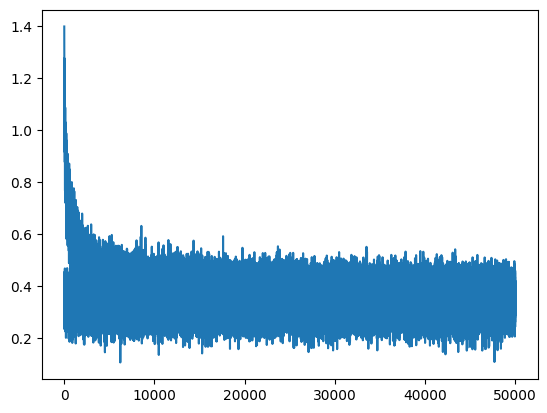

In [327]:
plt.plot(stepi, lossi)

In [323]:
# Evaluate the loss for the entire dataset after a minibatch multistep train
emb = C[Xtr] # shape [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1698, grad_fn=<NllLossBackward0>)

In [324]:
# Evaluate the loss for the entire dataset after a minibatch multistep train
emb = C[Xdev] # shape [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2019, grad_fn=<NllLossBackward0>)

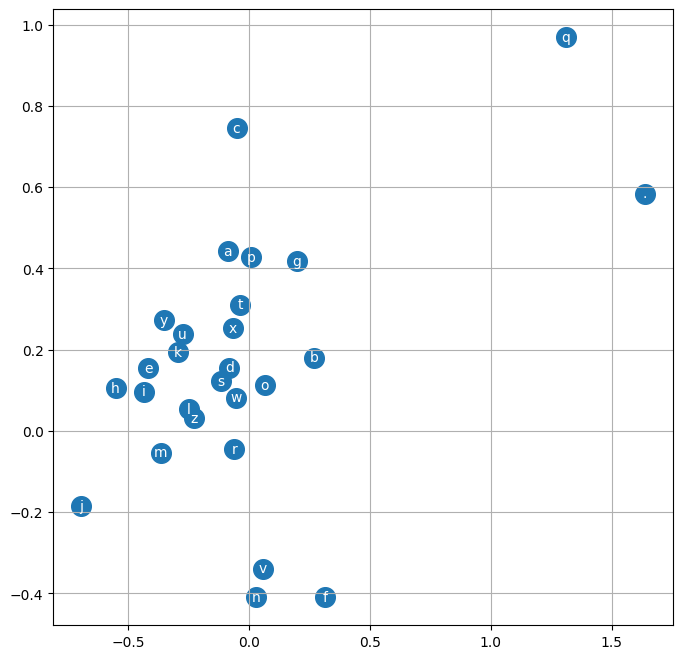

In [325]:
# Visualize the embedding
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [166]:
logits.max(1)

torch.return_types.max(
values=tensor([ 7.7196,  7.5937, 13.9204,  ...,  8.8380, 12.8418, 10.7132],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 18,  9,  ..., 18, 11, 17]))

In [168]:
# Use minibatches
torch.randint(0, X.shape[0], (32,))

tensor([199417, 158397, 204951,  63112,   4729, 180092, 186627, 165316, 197436,
         57609, 101771,  21705, 157852,  20979, 181318,    300, 158061,  92879,
        144536, 165047, 187666,  66523,  20525, 170373, 154981,  91486,  27199,
        198375, 140220,  43395, 166427,  17340])

In [171]:
# Is much more valuable and faster to have an aproximate gradient and
# make more steps, than to have an exact gradient and take fewer steps

In [ ]:
# Training split, dev/validation split, test split
# 80%, 10%, 10%

In [399]:
# Give a fixed seed for reproducibility
g = torch.Generator().manual_seed(2147483647)
# Build the lookup table for context sequences, which stores the embeddings
C = torch.randn((27, 10), generator=g)
# Initialize weights and biases for the first and the second layer
W1 = torch.randn((30, 250), generator=g) 
b1 = torch.randn(250, generator=g)
W2 = torch.randn((250, 27), generator=g)
b2 = torch.randn(27, generator=g)
# Gather all parameters in a single list
parameters = [C, W1, b1, W2, b2]#

In [400]:
# Compute number of parameters
sum(p.nelement() for p in parameters)

14797

In [401]:
# Initialize vectors that will keep track of what learning rates we used
# and when
lri = []
lossi = []
stepi = []

In [402]:
for p in parameters:
    p.requires_grad = True

In [403]:
for i in range(200000):
    # Minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (32,))
    # Forward pass
    # Create the embeddings encodings for all the inputs
    emb = C[Xtr[idx]] # shape [32, 3, 2]
    # Apply first layer and tanh activation function
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
    # Apply second layer
    logits = h @ W2 + b2
    # Count, probs and loss lines above are equal to
    loss = F.cross_entropy(logits, Ytr[idx])
    
    #print(loss.item())
    # Backward pass
    # Set the gradients to 0
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    # Dynamically adjust the learning rate
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
    
#print(loss.item())

In [404]:
# Evaluate the loss for the entire dataset after a minibatch multistep train
emb = C[Xtr] # shape [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1153, grad_fn=<NllLossBackward0>)

In [405]:
# Evaluate the loss for the entire dataset after a minibatch multistep train
emb = C[Xdev] # shape [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1804, grad_fn=<NllLossBackward0>)

In [406]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        #print(emb.shape)
        #print(emb.view(1, -1).shape)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print("".join([itos[i] for i in out]))

carmaizaar.
hari.
kimri.
reatlahnanden.
jazonte.
amerah.
jareei.
ner.
kia.
chaiir.
kaleigh.
ham.
joce.
quinn.
shon.
raiva.
bia.
jaelo.
dearyn.
kai.
